In [1]:
import os

from skimage.io import imread
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from random import choice

from utils.datasets import get_yoga_dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
yoga_classes = get_yoga_dataset()

Checking for yoga data in D:\Dropbox\Projects\clipsperiments\data\yoga.
Got 196 files for class Downdog.
Got 198 files for class Warrior2.
Got 198 files for class Tree.
Got 197 files for class Plank.
Got 199 files for class Goddess.


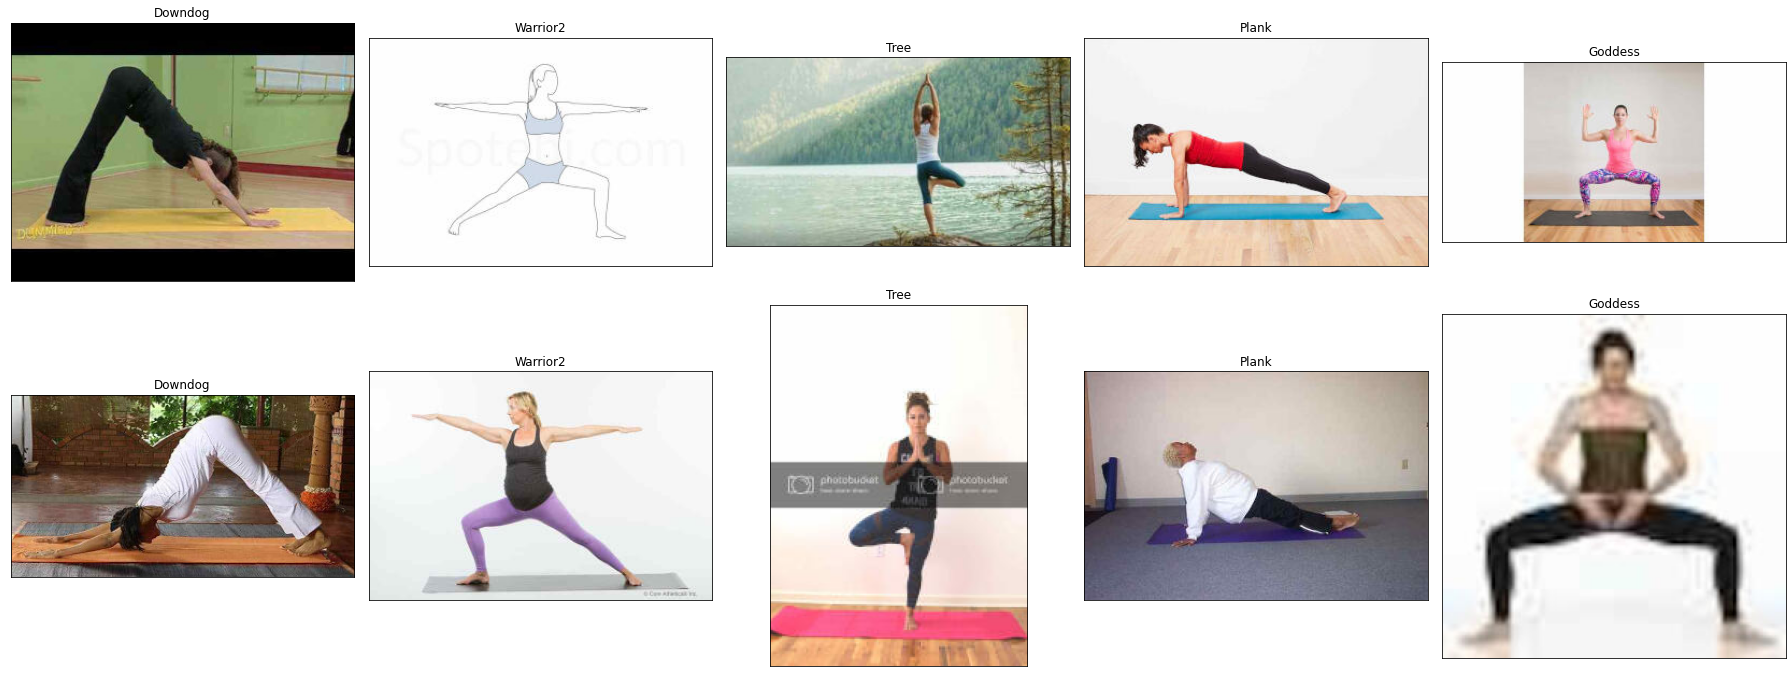

In [57]:
fig, axes = plt.subplots(2, len(yoga_classes), figsize=(25, 10))
for i, (cls, files) in enumerate(yoga_classes.items()):
    for j in range(2):
        first_image_path = choice(files)
        first_image = imread(first_image_path)
        axes[j][i].imshow(first_image)
        axes[j][i].set_title(cls)
        axes[j][i].axes.xaxis.set_visible(False)
        axes[j][i].axes.yaxis.set_visible(False)
fig.tight_layout()

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
processor.feature_extractor

CLIPFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 224
}

Recall [0.03571429 0.92929293 0.04545455 0.85786802 0.28643216]
Precision [1.         0.37322515 0.9        0.61904762 0.27804878]
Recall [0.15306122 0.93434343 0.04545455 0.87817259 0.26130653]
Precision [0.83333333 0.36561265 0.9        0.65779468 0.30057803]
Recall [0.20918367 0.34343434 0.16666667 0.72588832 0.03517588]
Precision [0.52564103 0.36956522 0.23239437 0.24783362 1.        ]


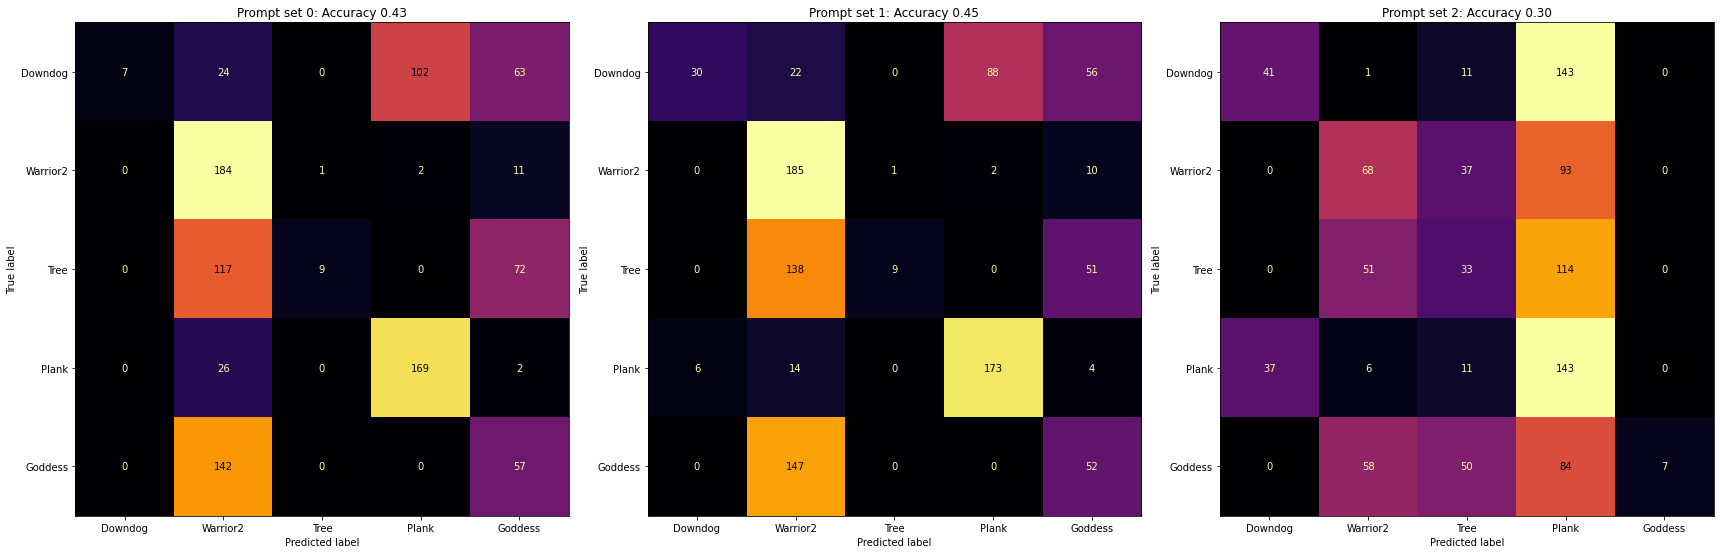

In [53]:
from utils.inference import evaluate_prompt_set_for_classes
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score

prompt_set = [[ cls + " yoga pose" for cls in yoga_classes.keys()],
              ["downward dog yoga pose", "warrior two yoga pose", "tree yoga pose", "plank yoga pose", "goddess yoga pose"],
              ["Adho mukha svanasana", "Virabhadrasana II", "Vrikshasana", "Phalakasana", "Utkata Konasana"]]
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for idx, prompts in enumerate(prompt_set):
    preds, labels = evaluate_prompt_set_for_classes(model, processor, yoga_classes, prompts, device)
    recall = recall_score(labels, preds, average=None)
    precision = precision_score(labels, preds, average=None)
    accuracy = accuracy_score(labels, preds)
    print("Recall", recall)
    print("Precision", precision)
    ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(yoga_classes.keys()), ax=axes[idx], colorbar=False, cmap="inferno")
    axes[idx].set_title(f"Prompt set {idx}: Accuracy {accuracy:.2f}")
fig.tight_layout()

Recall [0.67857143 0.85858586 0.07575758 0.79187817 0.18090452]
Precision [0.67857143 0.36170213 0.78947368 0.7255814  0.40909091]
Recall [0.60714286 0.87878788 0.06060606 0.82741117 0.2361809 ]
Precision [0.77272727 0.38839286 0.85714286 0.71179039 0.32867133]
Recall [0.25       0.02525253 0.35353535 0.79695431 0.00502513]
Precision [0.59756098 0.45454545 0.24390244 0.26166667 0.125     ]


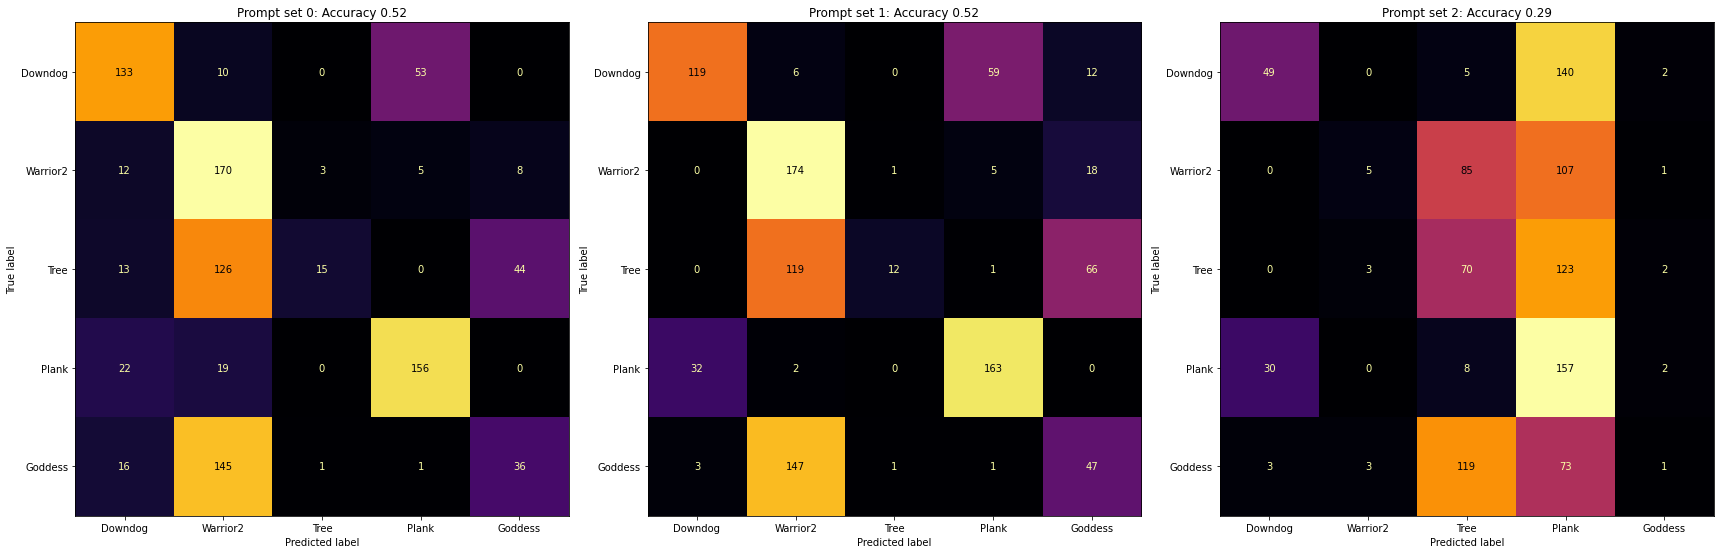

In [55]:
prompt_set2 = [["a photo of " + prompt for prompt in p] for p in prompt_set]
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for idx, prompts in enumerate(prompt_set2):
    preds, labels = evaluate_prompt_set_for_classes(model, processor, yoga_classes, prompts)
    recall = recall_score(labels, preds, average=None)
    precision = precision_score(labels, preds, average=None)
    accuracy = accuracy_score(labels, preds)
    print("Recall", recall)
    print("Precision", precision)
    ConfusionMatrixDisplay.from_predictions(labels, preds, display_labels=list(yoga_classes.keys()), ax=axes[idx], colorbar=False, cmap="inferno")
    axes[idx].set_title(f"Prompt set {idx}: Accuracy {accuracy:.2f}")
fig.tight_layout()

In [67]:
intel_dl_path = Path("./intel")
# api.dataset_download_files('puneet6060/intel-image-classification', path=intel_dl_path, quiet=False, unzip=True)

In [68]:
intel_data_path = intel_dl_path / "seg_test" / "seg_test"
classes = [f.stem for f in intel_data_path.glob("*") if f.is_dir()]
classes

['buildings', 'sea', 'street', 'mountain', 'glacier', 'forest']

buildings 437 (150, 150, 3)
sea 510 (150, 150, 3)
street 501 (150, 150, 3)
mountain 525 (150, 150, 3)
glacier 553 (150, 150, 3)
forest 474 (150, 150, 3)


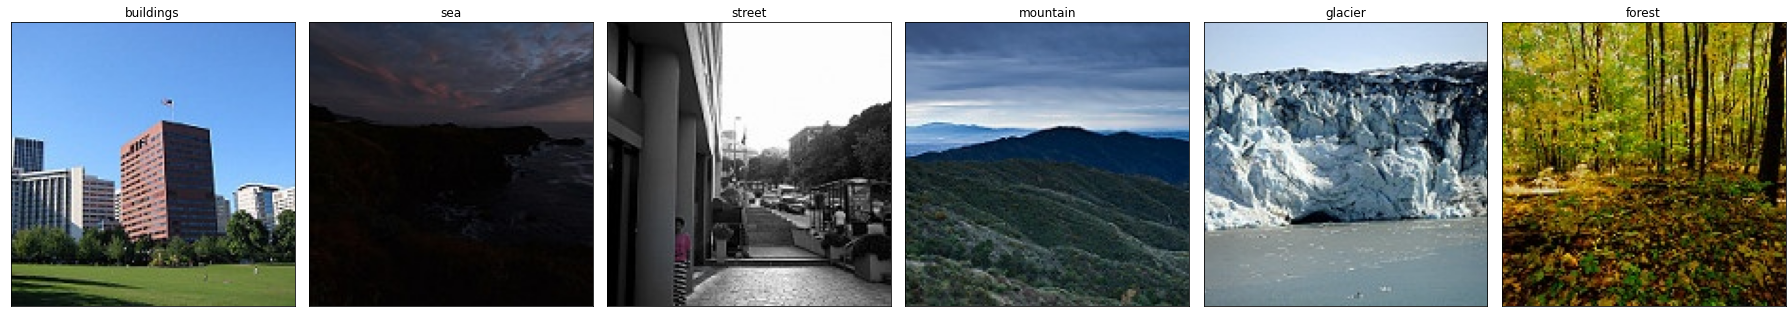

In [69]:
fig, axes = plt.subplots(1, len(classes), figsize=(25, 5))
for i, cls in enumerate(classes):
    image_paths = list((intel_data_path / cls).glob("*.jpg"))
    first_image_path = choice(image_paths)
    first_image = imread(first_image_path)
    print(cls, len(image_paths), first_image.shape)
    axes[i].imshow(first_image)
    axes[i].set_title(cls)
    axes[i].axes.xaxis.set_visible(False)
    axes[i].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

In [72]:
prompt_set = [[cls for cls in classes]]
with torch.no_grad():
    for prompts in prompt_set:
        print(prompts)
        acc_total = 0
        for i, cls in enumerate(classes):
            image_paths = list((intel_data_path / cls).glob("*.jpg"))
            images = [Image.open(p) for p in image_paths]

            inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True).to("cuda")

            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1).cpu().numpy()
            preds = np.bincount(probs.argmax(1), minlength=len(classes))
            acc = preds[i]/len(image_paths)
            print(f"{cls} {preds} {100*acc:.2f}%")
            acc_total += acc
        print(f"Avg accuracy: {acc_total/len(classes)}")
        print()
        

['buildings', 'sea', 'street', 'mountain', 'glacier', 'forest']


RuntimeError: CUDA out of memory. Tried to allocate 986.00 MiB (GPU 0; 7.80 GiB total capacity; 4.81 GiB already allocated; 668.31 MiB free; 6.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [57]:
import shutil
fruit_dl_path = Path("./fruits")
api.dataset_download_files('moltean/fruits', path=fruit_dl_path, quiet=False, unzip=True)
fruit_root_folder = fruit_dl_path / "fruits-360-original-size" / "fruits-360-original-size"
for folder in ["Training", "Validation", "Test"]:
    for sub_folder in (fruit_root_folder / folder).glob("*"):
        cls = "_".join(sub_folder.stem.split("_")[:-1])
        os.makedirs(fruit_root_folder / folder / cls, exist_ok=True)
        shutil.move(sub_folder, fruit_root_folder / folder / cls / sub_folder.stem)

100%|██████████| 1.28G/1.28G [01:00<00:00, 22.9MB/s]


In [58]:
fruit_data_path = fruit_dl_path / "fruits-360-original-size" / "fruits-360-original-size" / "Test"
classes = [f.stem for f in fruit_data_path.glob("*") if f.is_dir()]
classes

['cucumber',
 'zucchini',
 'apple_red_delicios',
 'apple_braeburn',
 'pear',
 'carrot',
 'cabbage_white',
 'apple_granny_smith',
 'apple_golden',
 'apple_crimson_snow',
 'apple',
 'zucchini_dark',
 'apple_red_yellow',
 'eggplant_violet',
 'apple_red',
 'apple_pink_lady',
 'apple_hit',
 'apple_rotten']

apple_granny_smith 160 (446, 475, 3)
apple_red_yellow 154 (323, 332, 3)
zucchini 80 (1011, 281, 3)
carrot 50 (665, 186, 3)
zucchini_dark 80 (830, 210, 3)


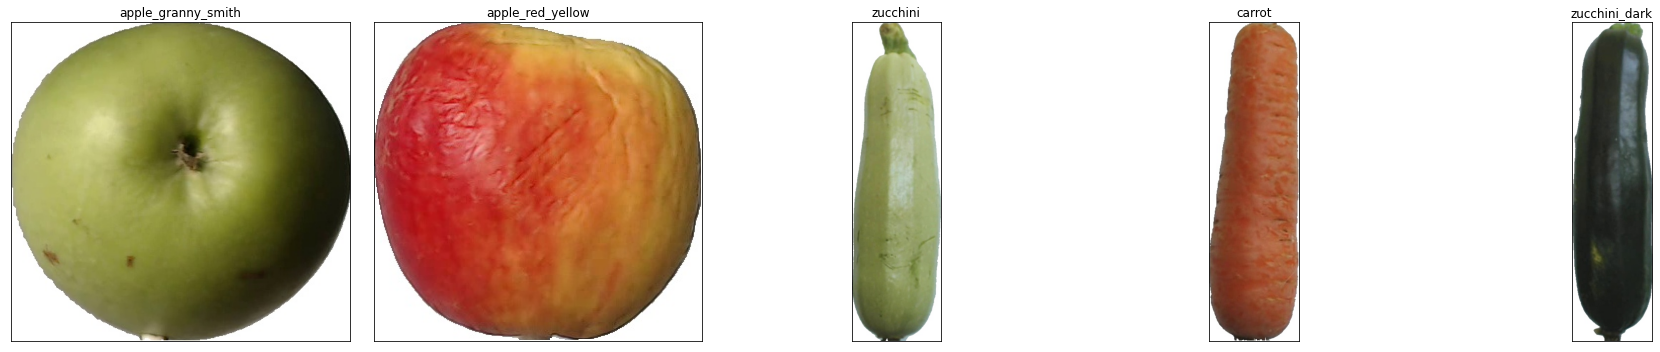

In [59]:
plt_classes = list(np.random.choice(classes, size=5))
fig, axes = plt.subplots(1, len(plt_classes), figsize=(25, 5))
for i, cls in enumerate(plt_classes):
    image_paths = list((fruit_data_path / cls).glob("**/*.jpg"))
    first_image_path = choice(image_paths)
    first_image = imread(first_image_path)
    print(cls, len(image_paths), first_image.shape)
    axes[i].imshow(first_image)
    axes[i].set_title(cls)
    axes[i].axes.xaxis.set_visible(False)
    axes[i].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

In [62]:
prompt_set = [[" ".join(cls.split("_")) for cls in classes]]
with torch.no_grad():
    for prompts in prompt_set:
        print(prompts)
        acc_total = 0
        for i, cls in enumerate(classes):
            image_paths = list((fruit_data_path / cls).glob("**/*.jpg"))
            images = [Image.open(p) for p in image_paths]

            inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True).to("cuda")

            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1).cpu().numpy()
            preds = np.bincount(probs.argmax(1), minlength=len(classes))
            acc = preds[i]/len(image_paths)
            print(f"{cls} {preds} {100*acc:.2f}% {classes[preds.argmax()]}")
            acc_total += acc
        print(f"Avg accuracy: {acc_total/len(classes)}")
        print()

['cucumber', 'zucchini', 'apple red delicios', 'apple braeburn', 'pear', 'carrot', 'cabbage white', 'apple granny smith', 'apple golden', 'apple crimson snow', 'apple', 'zucchini dark', 'apple red yellow', 'eggplant violet', 'apple red', 'apple pink lady', 'apple hit', 'apple rotten']
cucumber [ 15 116   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0] 11.45% zucchini
zucchini [38 38  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0] 47.50% cucumber
apple_red_delicios [  0   0   0   0   6   0   0   0   0 133   0   0   0   0   3   0   0   8] 0.00% apple_crimson_snow
apple_braeburn [ 0  0  0 36  0  0  0  0  0  1  0  0  0  0 77  0  0 46] 22.50% apple_red
pear [  0   0   0   0 233   0   0   1   0   0   0   0   0   0   0   0   0   0] 99.57% pear
carrot [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0] 100.00% carrot
cabbage_white [ 6  0  0  0  0  0 34  1  0  0  0  0  0  0  0  0  0  6] 72.34% cabbage_white
apple_granny_smith [ 1  0  0  0 81  0  0 43  0  0  0  0  0  0  0  0 

In [71]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
model.to(device)
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, element

In [64]:
processor.feature_extractor

CLIPFeatureExtractor {
  "crop_size": 336,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 336
}